In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Binarizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import missingno as ns

import warnings
warnings.filterwarnings('ignore')

- iris data를 이용한 tree feature 중요도

In [2]:
# 분류기 생성
dtc_iris = DecisionTreeClassifier(random_state=100)

# 데이터 로드 및 전처리
from sklearn.datasets import load_iris
iris_data = load_iris()

# 학습 데이터, 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size=.2, random_state=100)

# 학습
dtc_iris.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

In [3]:
from sklearn.tree import export_graphviz

# export_graphviz( )의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함
export_graphviz(dtc_iris, out_file="./data/tree.dot", class_names = iris_data.target_names, 
                           feature_names = iris_data.feature_names, impurity=True, filled=True)


In [6]:
!pip install graphviz

In [4]:
import os
os.environ["PATH"]+=os.pathsep+'C:/Program Files (x86)/Graphviz2.38/bin/'

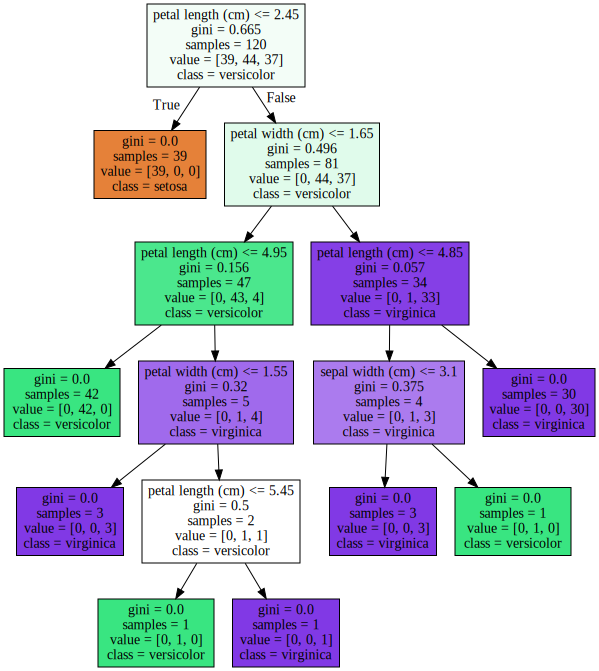

In [7]:
import graphviz

with open('./data/tree.dot') as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

In [8]:
print('feature importance : ', dtc_iris.feature_importances_)

feature importance :  [0.         0.01880092 0.58591345 0.39528563]


sepal length (cm) 0.0
sepal width (cm) 0.01880091915604763
petal length (cm) 0.5859134473686348
petal width (cm) 0.39528563347531753


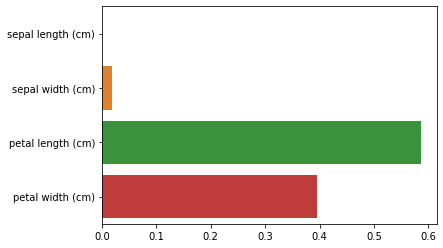

In [10]:
for name, value in zip(iris_data.feature_names,dtc_iris.feature_importances_):
    print(name, value)

sns.barplot(x=dtc_iris.feature_importances_, y=iris_data.feature_names)

#### 의사 결정 트리의 단점
- 과적합(학습데이터에서 완벽한 성능을 보이지만 테스트에서 성능이 좋지 않은 경우)
- 과적합을 위해서 분류용 가상의 데이터를 생성 -> make_classification()

In [85]:
# 한글 폰트 문제 해결
import platform

from matplotlib import font_manager, rc
# plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~') 

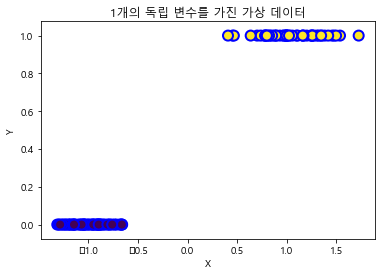

In [86]:
from sklearn.datasets import make_classification
plt.title('1개의 독립 변수를 가진 가상 데이터')

X, y = make_classification(n_features=1, n_informative=1, n_redundant=0, 
                           n_clusters_per_class=1, random_state=100)
plt.scatter(X,y, marker='o',c=y, s=100, edgecolor='b', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

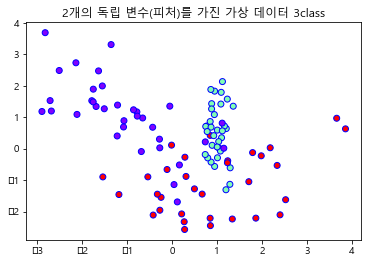

In [87]:
from sklearn.datasets import make_classification
plt.title('2개의 독립 변수(피처)를 가진 가상 데이터 3class')

X_features, y_labels = make_classification(n_features=2, n_informative=2, n_redundant=0, 
                           n_clusters_per_class=1, n_classes=3, random_state=0)

plt.scatter(X_features[:,0], X_features[:,1], c=y_labels, edgecolor='b', marker='o', cmap='rainbow')
plt.show()

In [21]:
# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)



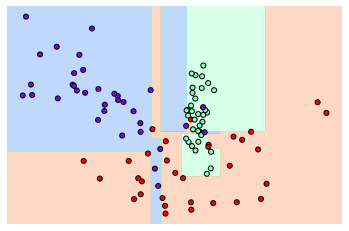

In [22]:
# 과적합 발생
sample_dtc_model = DecisionTreeClassifier().fit(X_features, y_labels)
visualize_boundary(sample_dtc_model, X_features, y_labels)

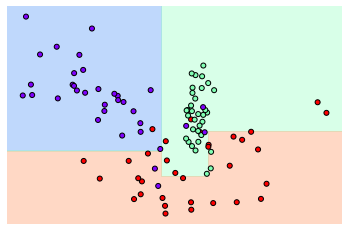

In [23]:
# 튜닝을 통한 과적합 해결
# max_depth 줄여서 트리의 깊이를 제한
# min_samples_split 높여서 데이터가 분할하는데 필요한 샘플 데이터 수를 높임
# min_samples_leaf 높여서 말단 노드가 되는데 필요한 샘플 데이터의 수를 높임
# max_features 높여서 분할을 하는데 고려하는 피처의 수 제한

sample_dtc_model = DecisionTreeClassifier(min_samples_leaf=6).fit(X_features, y_labels)
visualize_boundary(sample_dtc_model, X_features, y_labels)

### UCI HAR 결정트리 실습

In [41]:
# 데이터셋을 구성하는 함수 설정
def har_dataset():
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백문자를 sep으로 할당
    feature_name_df = pd.read_csv('./data/features.txt', sep='\s+',
                                                     header=None, names=['column_index', 'column_name'])
    # 데이터프레임에 피처명을 컬럼으로 뷰여하기 위해 리스트 객체로 다시 반환
    feature_name = feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터세트와 테스트 피처 데이터를 데이터프레임으로 로딩
    # 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/train/X_train.txt', sep='\s+', header=None)
    X_test = pd.read_csv('./data/test/X_test.txt', sep='\s+', header=None)
    
    # 학습 레이블과 테스트 레이블 데이터를 데이터 프레임으로 로딩, 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/train/y_train.txt', sep='\s+', names=['action'])
    y_test = pd.read_csv('./data/test/y_test.txt', sep='\s+', names=['action'])
    
    # 로드된 학습/테스트용 데이터프레임을 모두 반환
    return X_train, X_test, y_train, y_test


In [42]:
X_train, X_test, y_train, y_test = har_dataset()

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, 0 to 560
dtypes: float64(561)
memory usage: 31.5 MB


In [44]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [45]:
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

- 튜닝 없이 예측, 즉 디폴트로 예측한 결과

In [49]:
har_dtc = DecisionTreeClassifier(random_state=120)
# print('parameter:', har_dtc.get_params())
har_dtc.fit(X_train, y_train)
y_pred = har_dtc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Decision Tree 예측 값 : ', accuracy)

Decision Tree 예측 값 :  0.8598574821852731


In [51]:
# max_depth 가 정확도에 주는 영향
params = {
    'max_depth' : [6,8,10,12,16,20,24]
}
grid_cv=GridSearchCV(har_dtc, param_grid=params, scoring='accuracy', cv=5)
grid_cv.fit(X_train, y_train)
print('최고 평균 정확도 수치 : ', grid_cv.best_score_)
print('최적 하이퍼 파라미터 : ', grid_cv.best_params_)

최고 평균 정확도 수치 :  0.846573990575156
최적 하이퍼 파라미터 :  {'max_depth': 6}


In [54]:
# max_depth 가 크면 과적합으로 인해 성능이 하락하는지
max_depths = [6, 10, 12, 16, 20, 24, 28]
for depth in max_depths:
    har_dtc = DecisionTreeClassifier(max_depth=depth, random_state=100)
    har_dtc.fit(X_train, y_train)
    y_pred = har_dtc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('max_depth: ',depth, '정확도: ',accuracy)

max_depth:  6 정확도:  0.8537495758398371
max_depth:  10 정확도:  0.8673227010519172
max_depth:  12 정확도:  0.8561248727519511
max_depth:  16 정확도:  0.8544282321004412
max_depth:  20 정확도:  0.8506956226671191
max_depth:  24 정확도:  0.8506956226671191
max_depth:  28 정확도:  0.8506956226671191


In [55]:
# max_depth 가 정확도에 주는 영향
params = {
    'max_depth' : [6,8,10,12,16,20,24],
    'min_samples_split' : [16, 24]
}
grid_cv=GridSearchCV(har_dtc, param_grid=params, scoring='accuracy', cv=5)
grid_cv.fit(X_train, y_train)
print('최고 평균 정확도 수치 : ', grid_cv.best_score_)
print('최적 하이퍼 파라미터 : ', grid_cv.best_params_)

최고 평균 정확도 수치 :  0.854742805347836
최적 하이퍼 파라미터 :  {'max_depth': 8, 'min_samples_split': 16}


In [59]:
# 해당 파라미터를 적용해서 예측 수행
best_params_dtc = grid_cv.best_estimator_
print(best_params_dtc)
best_pred = best_params_dtc.predict(X_test)
accuracy = accuracy_score(y_test, best_pred)
print('예측정확도: ', accuracy)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=16,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')
예측정확도:  0.8717339667458432


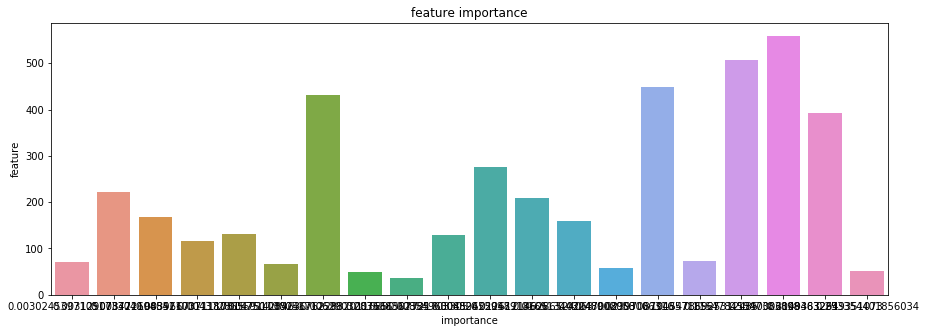

In [81]:
# best_params_dtc.feature_importances_

# 피처 중요도를 시각화 top20
feature_importance = pd.Series(best_params_dtc.feature_importances_, index=X_train.columns)
feature_top20 = feature_importance.sort_values(ascending=False)[:20]

df = pd.DataFrame(feature_top20, columns=['importance'])
df.index.name='feature'
df = df.reset_index()
df

plt.figure(figsize=(15,5))
plt.title('feature importance')
# sns.barplot(x=feature_top20.index, y=feature_top20)
sns.barplot(x='importance', y='feature', data=df)
plt.show()